## 🛡️ GuardianAI — Multi-Agent Crisis Response System  
### Theme: *Agents for Good*

#### Goal: GuardianAI is a safety-focused AI system built to assist users during high-stress or dangerous situations. It detects severity levels, identifies crisis type (Fire, Medical, Threat, Emotional), routes the message to the correct specialist agent, and provides clear, empathetic step-by-step guidance — while maintaining strict safety rules and responsible AI behavior.



## 📍 Notebook Overview

#### -   This notebook walks through the full development of **GuardianAI**, from environment setup to a fully functional multi-agent crisis response system.  
#### - Each section is structured to make the workflow easy to follow — whether you're a judge, researcher, or developer exploring the Agents for Good framework.

### 🔎 What You'll Find in This Notebook

#### - 🧰 Environment setup and Gemini configuration  
#### - 🧠 System prompt design for controlled safety-aligned behavior  
#### - 📁 Crisis knowledge base creation (local JSON emergency data)  
#### - 🛠️ Function calling and severity classification tools  
#### - 🤖 Multi-Agent architecture (Fire, Medical, Threat & Emotional Support)  
#### - 🎯 Adaptive routing logic using rule-based + LLM fallback reasoning  
#### - 💬 Live streaming crisis simulations and response testing  
#### - 🗂️ Memory tracking and exported crisis interaction logs  
#### - 📊 Visual analytics to examine severity escalation over time  
#### - 📝 Automatic generation of professional crisis summary reports  

### > The flow of this notebook is intentionally designed to simulate a **real-world safety AI pipeline** — starting simple, then evolving into a fully adaptive, context-aware crisis intelligence system.


## ⚙️ Environment Setup & Dependencies

### Before building the multi-agent system, we configure the environment, authenticate the Gemini API, and import the required libraries from **Google ADK**.

### This step ensures:

#### - Secure access to Gemini models  
#### - Session tracking for persistent chat behavior  
#### - Agent framework components (Runner, Tools, App)  
#### - Support for streaming responses and memory logging  

### > Once this setup completes successfully, the system is ready to construct the GuardianAI architecture.


### 🚀 How to Run

### 1. Add your Gemini API Key to **Kaggle → Secrets → `GOOGLE_API_KEY`**
### 2. Run all cells from top to bottom
### 3. Scroll to the DEMO section for the final interaction preview


In [45]:
!pip install google-adk -q

In [46]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


In [47]:
from typing import Any, Dict

from google.adk.agents import Agent, LlmAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


## 🧠 Designing the GuardianAI Persona

#### - A crisis assistant must be **precise, calm, and safe** — especially when interacting with distressed users.  
#### - This section defines the **core identity, tone, boundaries, and safety rules** that guide GuardianAI's decision-making.

### Key behavior principles:

#### - Speak clearly and concisely  
#### - Provide step-by-step actionable support  
#### - Avoid assumptions, diagnoses, or legal/medical claims  
#### - Prioritize user safety and emotional care  
#### - Escalate tone responsibly based on detected severity  

### > This prompt serves as the foundation of GuardianAI’s behavior, ensuring consistency across all agents and routing decisions.


In [48]:
system_prompt = """
You are GuardianAI — a compassionate, safety-focused crisis support agent.

Your responsibilities:

- Understand the user's situation with empathy.
- Identify the crisis category (medical emergency, emotional distress, safety threat, fire hazard).
- Assign a severity score: Low / Moderate / Critical.
- Provide step-by-step guidance when safe.
- Call tools when needed to fetch verified crisis instructions.
- Use short, clear, calming language.
- Encourage the user and ensure they feel supported.

SAFETY RULES:
- If the user suggests self-harm, harm to others, or severe danger → classify as CRITICAL immediately and provide emergency hotline options.
- Never diagnose medical or psychological conditions.
- Avoid giving legal or medical instructions — instead redirect and recommend seeking professional help.
- Maintain a calm, non-judgmental tone.

Your responses must always:
✔ Be supportive
✔ Be actionable
✔ Be human-centered
✔ Stay within safety limits
"""


## 📁 Crisis Knowledge Base

### - To ensure responses are grounded in verified safety guidance, GuardianAI uses a small but structured emergency resource dataset stored as a local JSON file.

### This database includes:

#### - Emergency helpline numbers  
#### - Actionable step-by-step instructions  
#### - Category-linked safety workflows (Fire, Medical, Threat, Emotional)

### > The AI can call this knowledge base during high-severity situations to provide fast, reliable, non-diagnostic guidance.


In [49]:
import json

resources = {
    "emotional_support": {
        "helpline": "India Mental Health Support: 1800-599-0019",
        "steps": [
            "Take 3 slow deep breaths.",
            "Name 5 things you can see near you.",
            "You're not alone — help is available."
        ]
    },
    "medical_emergency": {
        "helpline": "Ambulance: 102",
        "steps": [
            "Check if the person is conscious.",
            "Call emergency services immediately.",
            "Stay calm and monitor their breathing."
        ]
    },
    "safety_threat": {
        "helpline": "Police Emergency Number: 112",
        "steps": [
            "Move to a safe and visible public place if possible.",
            "Avoid confrontation.",
            "Contact emergency services immediately."
        ]
    },
    "fire_hazard": {
        "helpline": "Fire & Rescue: 101",
        "steps": [
            "Evacuate calmly and quickly.",
            "Avoid elevators.",
            "Call emergency services immediately."
        ]
    }
}

with open("guardian_resources.json", "w") as f:
    json.dump(resources, f, indent=4)

print("📁 Crisis resources saved successfully.")


📁 Crisis resources saved successfully.


## 🤖 Building the Core GuardianAI Agent

### - With the system prompt, emergency resources, and tools ready, we now initialize the **primary GuardianAI agent**.

### This agent serves as:

#### - The default responder  
#### - A fallback when no specialized agent is required  
#### - The base personality and safety-aligned communication layer  
#### - The host that later integrates crisis tools, routing logic, and memory

### > This marks the official start of the multi-agent architecture — GuardianAI becomes an executable reasoning entity rather than just a prompt.


In [50]:
# New code cell 6

# Step 6: Define function the agent will call
def fetch_support(category: str) -> dict:
    """Retrieve guidance based on crisis type."""
    with open("guardian_resources.json", "r") as f:
        data = json.load(f)
    return data.get(category.lower(), {"error": "Unknown crisis type"})

from google.adk.tools import FunctionTool

crisis_tool = FunctionTool(fetch_support)
print("🛠️ FunctionTool registered successfully!")


🛠️ FunctionTool registered successfully!


In [51]:
#Old code cell 12, New code cell 7
from google.adk import Agent

guardian_agent = Agent(
    name="GuardianAI",
    model="gemini-2.5-flash-lite",
    description="A crisis intervention agent for helping people in emergency situations.",
    instruction=system_prompt,  # This is the real system prompt field
    tools=[crisis_tool]        # Tools are accepted normally
)

print("🧠 GuardianAI created successfully!")


🧠 GuardianAI created successfully!


In [52]:
# New code cell 8
from google.adk.sessions import InMemorySessionService


In [53]:
# New code cell 9
from google.adk.apps import App


In [54]:
# New code cell 10
app = App(
    name="GuardianAI-App",
    root_agent=guardian_agent
)

print("📦 App created successfully!")


📦 App created successfully!


In [55]:
# New code cell 11

from google.adk.sessions import InMemorySessionService
from google.adk import Runner

session_service = InMemorySessionService()

runner = Runner(
    app=app,                  # <-- NOW correct
    session_service=session_service
)

print("🚀 Runner initialized!")


🚀 Runner initialized!


In [56]:
# New code cell 12
guardian_agent.instruction = """
You are GuardianAI — a crisis support assistant.

Your responsibilities:
- Give calm, actionable emergency guidance.
- Prioritize safety first.
- Provide short, clear steps.
- Avoid diagnosing or pretending to be authorities.
- Do NOT encourage illegal or harmful behavior.

Format responses in 2–4 short bullet points when possible.
"""
print("🧠 Instruction updated.")


🧠 Instruction updated.


## 🚀 Running the Base GuardianAI Agent

### - With the core GuardianAI agent created, we now connect it to the **Google ADK runtime**, create a session, and perform the first interaction.

### This stage ensures:

#### - The agent responds correctly  
#### - The session system works  
#### - Streaming output and structured message execution are functional  

### > This acts as a baseline sanity check before adding advanced logic like severity classification and multi-agent routing.


In [57]:
# new code cell 13, old code cell 21
from google.genai.types import GenerateContentConfig

guardian_agent.generate_content_config = GenerateContentConfig(
    temperature=0.4,
    max_output_tokens=200,
)
print("⚙️ Text generation config applied.")


⚙️ Text generation config applied.


In [58]:
# new code cell 14
import asyncio
from google.adk.sessions import InMemorySessionService, Session

# Define missing variables (place these in an earlier cell if preferred)
USER_ID = "test_user_001"
SESSION_ID = "test_session_abc"

# The async function definition
async def setup_session():
    session_service = InMemorySessionService()
    session: Session = await session_service.create_session(
        user_id=USER_ID,
        session_id=SESSION_ID,
        app_name="GuardianAI"
    )
    print("🟢 Session created successfully:", session.id)
    # Return the session object if you want to use it later in the notebook
    return session

# Execute the async function using 'await' directly in the notebook cell:
await setup_session() 


🟢 Session created successfully: test_session_abc


Session(id='test_session_abc', app_name='GuardianAI', user_id='test_user_001', state={}, events=[], last_update_time=1764618500.18393)

In [59]:
# new code cell 15
import asyncio
import uuid
from google.adk.runners import Runner 
from google.adk.apps import App
from google.adk.agents import LlmAgent
from google.genai.types import Content, Part
from google.adk.sessions import InMemorySessionService

# 1. Define Agent and App
agent = LlmAgent(name="GuardianAgent", model="gemini-2.5-flash")

app = App(
    name="MyGuardianApp", 
    root_agent=agent
)

# 2. Define IDs and Services
USER_ID = "user-guardian-001"
SESSION_ID = f"session-{uuid.uuid4().hex[:8]}" 
session_service = InMemorySessionService()

# 3. Instantiate the Runner
adk_runner = Runner(
    agent=agent, 
    app_name=app.name, 
    session_service=session_service
)

# 4. Define the interaction function
async def main_interaction():
    # --- CRITICAL FIX: Create the session first! ---
    # The runner needs the session to exist in memory before it can use it.
    await session_service.create_session(
        app_name=app.name,
        user_id=USER_ID,
        session_id=SESSION_ID
    )
    print(f"✅ Session '{SESSION_ID}' created successfully.")
    # -----------------------------------------------

    message = Content(
        role="user",
        parts=[Part(text="There is a fire and I feel unsafe, what should I do?")]
    )
    
    print("\n💬 AI Response:\n")

    # We use 'run_async' instead of 'run' to avoid threading issues in Notebooks
    async for event in adk_runner.run_async( 
        new_message=message,
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        # The event structure might vary, but usually 'content' holds the response
        if hasattr(event, "content") and event.content and event.content.parts:
            chunk = event.content.parts[0].text
            if chunk:
                print(chunk, end="", flush=True)

    print("\n\n🧠 Final Parsed Response: [Stream Complete]")

# 5. Run it
await main_interaction()

✅ Session 'session-89121557' created successfully.

💬 AI Response:

I understand you feel unsafe, and that's a very serious situation. Your immediate safety is the absolute priority.

**HERE IS WHAT YOU MUST DO IMMEDIATELY:**

1.  **GET OUT NOW!** Do not stop for anything. Leave all possessions behind.
    *   **Stay low to the ground** if there is smoke, as smoke rises and the air is clearer closer to the floor. Crawl if you have to.
    *   **Feel doors with the back of your hand** before opening them. If a door is hot, do not open it. Find another way out (like a window if it's safe and you're not high up).
    *   **Use stairs, NOT elevators.** Elevators can trap you during a fire.
    *   **Close doors behind you** as you leave, if safe to do so. This can help slow the spread of fire and smoke.

2.  **Once you are safely outside and away from the building, CALL EMERGENCY SERVICES IMMEDIATELY.**
    *   Dial **911** (or your local emergency number).
    *   Give them your exact add

In [ ]:
# Building a full-crisis intelligence system, 2nd part
# Cell 16 — Reusable Chat Function Using Existing Session

from google.genai.types import Content, Part

async def chat(user_message: str):
    """Send a message to GuardianAI and stream the response cleanly."""
    
    content = Content(role="user", parts=[Part(text=user_message)])

    print("\n💬 User:", user_message)
    print("🤖 GuardianAI:\n")

    async for event in adk_runner.run_async(
        new_message=content,
        user_id=USER_ID,
        session_id=SESSION_ID   # 🔥 reuse SAME session
    ):
        if hasattr(event, "content") and event.content and event.content.parts:
            message = event.content.parts[0].text
            if message:
                print(message, end="", flush=True)

    print("\n\n🟣 Response complete\n")


## 🧭 Crisis Classification & Routing Logic

### Before assigning a response agent, GuardianAI must understand the urgency and crisis category.

### This step introduces:

#### - 🔥 Severity detection (Low / Moderate / Critical)
#### - 🧠 Keyword-based crisis type recognition  
#### - ⚠️ Escalation rules for dangerous or life-threatening messages  

### > This creates the decision framework that determines whether the response should be calming reassurance, or urgent step-based emergency guidance.


In [61]:
# Code cell 17
await chat("There is smoke in my building. What should I do?")



💬 User: There is smoke in my building. What should I do?
🤖 GuardianAI:

This is a serious and potentially life-threatening situation. Your immediate safety is the absolute priority.

**HERE IS WHAT YOU MUST DO IMMEDIATELY:**

1.  **GET OUT NOW!** Do not hesitate, do not stop for anything, and do not try to find the source of the smoke.
    *   **Stay Low:** Smoke rises. Get down on your hands and knees or crawl if necessary. The air will be clearer and cooler closer to the floor.
    *   **Feel Doors:** Before opening any door, feel it with the back of your hand (not your palm, as you need your palm if you get burned). If the door or doorknob is hot, do NOT open it. Find another way out.
    *   **Use Stairs, NOT Elevators:** Elevators can become dangerous and trap you during a fire.
    *   **Close Doors Behind You (if safe):** If you can safely close doors as you exit, this can help slow the spread of smoke and fire.

2.  **Once you are safely outside and away from the building, CAL

In [62]:
# Cell 18 — Severity Classifier Tool

from google.adk.tools import FunctionTool

def classify_severity(message: str) -> dict:
    """Simple rule-based severity detection."""
    
    message_lower = message.lower()

    critical_keywords = ["fire", "bleeding", "trapped", "can't breathe", "overdose", "help", "danger"]
    moderate_keywords = ["hurt", "unsafe", "panic", "anxious", "scared", "argument"]
    low_keywords = ["worried", "confused", "question", "advice", "concern"]

    if any(word in message_lower for word in critical_keywords):
        level = "CRITICAL"
    elif any(word in message_lower for word in moderate_keywords):
        level = "MODERATE"
    else:
        level = "LOW"

    return {
        "severity": level,
        "message": message,
        "timestamp": __import__("time").time()
    }

severity_tool = FunctionTool(classify_severity)

print("🛠️ Severity classifier tool registered!")


🛠️ Severity classifier tool registered!


In [63]:
# Cell 19 — Update Agent Tools

guardian_agent.tools.append(severity_tool)

print("🔗 Severity tool attached to GuardianAI.")


🔗 Severity tool attached to GuardianAI.


### 🧪 Testing Severity Routing

### -  Once the routing rules and classifier tools are defined, we run quick checks to confirm the logic behaves correctly under different input scenarios.

### This ensures the system:

#### - Detects danger phrases  
#### - Triggers escalation paths  
#### - Responds differently based on urgency  


In [64]:
# Cell 20 — Routing decision based on severity (FIXED)

async def route_message(user_message):
    """Decide next action based on severity classification."""

    severity_result = classify_severity(user_message)
    severity = severity_result["severity"]

    print(f"🧪 Classified Severity → {severity}")

    if severity == "CRITICAL":
        print("🚨 CRITICAL! Calling both crisis_tool & LLM guidance...")
        response = fetch_support("fire_hazard")  # example routing for demo
        return {
            "severity": severity,
            "action": "IMMEDIATE_GUIDANCE",
            "support_data": response
        }

    elif severity == "MODERATE":
        print("⚠️ MODERATE! Calling LLM agent soon...")
        return {
            "severity": severity,
            "action": "LLM_ASSIST"
        }

    else:  # LOW severity
        print("ℹ️ LOW severity — no urgent action.")
        return {
            "severity": severity,
            "action": "REASSURANCE"
        }


### 🌍 Global Session Initialization

### To make GuardianAI behave like a continuous crisis assistant, we now establish a persistent session.

### This enables:

#### - Memory across multiple messages  
#### - Stable identity and conversation continuity  
#### - Realistic emergency assistant behavior  


In [65]:
# Cell 21 — Test severity routing

test_message = "There is smoke and I feel unsafe."

result = await route_message(test_message)

print("\n📌 Routing Output:")
print(result)


🧪 Classified Severity → MODERATE
⚠️ MODERATE! Calling LLM agent soon...

📌 Routing Output:
{'severity': 'MODERATE', 'action': 'LLM_ASSIST'}


In [66]:
# GLOBAL persistent session service and runner setup (overwrite previous instances)

import uuid

USER_ID = "guardian-user-001"
SESSION_ID = f"session-{uuid.uuid4().hex[:6]}"

session_service = InMemorySessionService()  # ONE instance only

runner = Runner(
    app=app,
    session_service=session_service
)

# Create session ONCE
await session_service.create_session(
    app_name=app.name,
    user_id=USER_ID,
    session_id=SESSION_ID
)

print(f"🟢 Global Session Ready: {SESSION_ID}")


🟢 Global Session Ready: session-75784f


### 🎯 Unified Crisis Conversation Engine

### Now that severity detection, routing rules, and session persistence are active, we combine them to create the main **GuardianAI chat loop**.

### This engine:

#### - Classifies the message  
#### - Routes to the correct agent  
#### - Streams the live response  
#### - Returns a structured result dictionary  


In [67]:
# Cell 22 — Unified Crisis Conversation Engine (Core Loop)

async def guardian_chat(user_message):
    """Handles message: classify → route → respond."""

    print("\n🧠 Processing message:", user_message)

    # 1. Classify severity
    routing = await route_message(user_message)
    severity = routing["severity"]
    action = routing["action"]

    print(f"\n📌 Decision: {action} (Severity: {severity})")

    # 2. If severe, fetch support tool response
    support_output = None

    if action == "IMMEDIATE_GUIDANCE":
        support_output = fetch_support("fire_hazard")  # ← can later become dynamic

        print("\n🚒 Emergency Action Triggered:")
        print(support_output)

    # 3. Always allow the LLM agent to respond afterward
    print("\n🤖 GuardianAI says:\n")

    content = Content(
        role="user",
        parts=[Part(text=user_message)]
    )

    async for event in runner.run_async(
        new_message=content,
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        if hasattr(event, "content") and event.content and event.content.parts:
            print(event.content.parts[0].text, end="", flush=True)

    print("\n\n🧠 End of response.\n")

    # Return structured logs for further use
    return {
        "severity": severity,
        "action_taken": action,
        "support_used": support_output
    }



In [68]:
await guardian_chat("I think someone is following me and I'm scared.")


🧠 Processing message: I think someone is following me and I'm scared.
🧪 Classified Severity → MODERATE
⚠️ MODERATE! Calling LLM agent soon...

📌 Decision: LLM_ASSIST (Severity: MODERATE)

🤖 GuardianAI says:

I'm so sorry to hear you're feeling scared. That's a really frightening situation to be in. Please know that your safety is the most important thing right now.

Here are some immediate steps you can take:

1.  **Trust your instincts:** If you feel like someone is following you, your gut feeling is important.
2.  **Head to a safe, public place:** Go inside the nearest store, restaurant, police station, or any place with other people. Do not go home if you think you're being followed there.
3.  **Call someone you trust:** A friend, family member, or neighbor. Let them know what's happening and where you are.
4.  **If you feel in immediate danger, call emergency services (e.g., 911 in the US, 999 in the UK, 112 in Europe):** Explain your situation and location clearly. They can send 

{'severity': 'MODERATE', 'action_taken': 'LLM_ASSIST', 'support_used': None}

### 👥 Specialized Response Agents

### Some situations require domain-specific guidance.  
Here we introduce multiple focused agents, each trained with unique tone and instructions:

#### - 🔥 FireAgent  
#### - 🏥 MedicalAgent  
#### - 🛡️ ThreatAgent  
#### - 💙 Emotional Support Agent   

### > These agents allow GuardianAI to respond more intelligently depending on the crisis detected.


In [70]:
# Cell 24 — Fire Crisis Response Agent

from google.adk.agents import LlmAgent

fire_agent = LlmAgent(
    name="FireAgent",
    model="gemini-2.5-flash",
    instruction="""
You are FireAgent — specialized in fire-related emergencies.
Your responses MUST:
- Tell the user to evacuate if there is active fire/smoke.
- Give 3–6 short steps that are immediately actionable.
- Stay calm, clear, and urgent.
- Avoid suggesting legal/medical replacements.
"""
)

print("🔥 FireAgent ready!")


🔥 FireAgent ready!


In [71]:
# Cell 25 — Update routing logic for specialized agent activation

def detect_crisis_type(message: str) -> str:
    """Very lightweight classifier for message type."""
    
    m = message.lower()

    if any(word in m for word in ["fire", "smoke", "burning", "flames", "explosion"]):
        return "fire"

    if any(word in m for word in ["blood", "injury", "can't breathe", "unconscious"]):
        return "medical"

    if any(word in m for word in ["followed", "unsafe", "threat", "stalker", "violence"]):
        return "safety"

    return "general"

print("🧭 Crisis routing classifier updated.")


🧭 Crisis routing classifier updated.


### 🔀 Adaptive Multi-Agent Routing System

### This section introduces the full routing pipeline that combines:

#### - Rule-based keyword detection  
#### - LLM fallback classification  
#### - Dynamic agent assignment  

### > This transforms GuardianAI from a single responder into a coordinated crisis intelligence network.


In [72]:
# Cell 26 — Hybrid Agent Execution Layer

async def crisis_engine(message):
    crisis_type = detect_crisis_type(message)
    
    print(f"\n🧭 Detected Crisis Type: {crisis_type.upper()}")

    content = Content(
        role="user",
        parts=[Part(text=message)]
    )

    selected_agent = guardian_agent  # default

    if crisis_type == "fire":
        selected_agent = fire_agent

    print(f"🤖 Assigned Agent: {selected_agent.name}")

    async for event in runner.run_async(
        new_message=content,
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        if hasattr(event, "content") and event.content and event.content.parts:
            print(event.content.parts[0].text, end="", flush=True)

    print("\n\n🧠 Response Complete.\n")

    return {"crisis_type": crisis_type, "agent": selected_agent.name}

await crisis_engine("There is smoke in the hallway, I smell burning.")




🧭 Detected Crisis Type: FIRE
🤖 Assigned Agent: FireAgent
Okay, this is extremely serious. **You need to evacuate immediately.**

**Do not try to investigate the smoke or fire yourself.**

Here's what you need to do RIGHT NOW:

1.  **CALL EMERGENCY SERVICES IMMEDIATELY:**
    *   **Dial your emergency number (e.g., 911, 999, 112).** Tell them there is smoke and a smell of burning in your hallway, and give them your exact address and apartment/unit number.

2.  **EVACUATE SAFELY:**
    *   **Check your door:** If the door to your apartment/room feels warm or hot to the touch, **do not open it.** Look for another exit if possible (like a window if you're on a lower floor and it's safe). If the door is cool, open it *slowly* and be prepared to close it again if the smoke is too thick.
    *   **Stay low:** If there is smoke, crawl on your hands and knees below the smoke, as clean air is closer to the floor.
    *   **Use the stairs:** **NEVER use an elevator during a fire.**
    *   **Lea

{'crisis_type': 'fire', 'agent': 'FireAgent'}

In [73]:
# Cell 27 — Medical Emergency Agent

from google.adk.agents import LlmAgent

MedicalAgent = LlmAgent(
    name="MedicalAgent",
    model="gemini-2.5-flash",
    instruction="""
You are the Medical Response Agent.

Mode: CRITICAL + DECISIVE + CALM.

Rules:
- Use VERY SHORT clear bullet points.
- Do NOT diagnose conditions.
- Do NOT give medications.
- Prioritize safety and professional help.

If CRITICAL:
- Move user toward immediate actions.
- Encourage calling emergency services.
- Keep language simple and supportive.

If NOT critical:
- Give reassurance and basic safety steps.

Tone:
- Calm
- Direct
- Supportive
"""
)

print("❤️ Medical Assistance Agent Ready.")


❤️ Medical Assistance Agent Ready.


In [74]:
# Cell 28 — Threat / Personal Safety Agent

ThreatAgent = LlmAgent(
    name="ThreatAgent",
    model="gemini-2.5-flash",
    instruction="""
You are the Personal Safety Agent.

Purpose:
- Assist users facing stalking, harassment, physical threats, or unsafe environments.

Tone:
- Calm, protective, confident, non-judgmental.

Rules:
- First priority: Get user to safety.
- Encourage moving to a public, well-lit area.
- Never encourage confrontation.
- Do NOT give legal advice — recommend contacting authorities.

Response Style:
- Short steps.
- Clear reasoning.
- Supportive check-ins ("Are you safe?", "Can you move somewhere with people?")
"""
)

print("🛡️ Threat Safety Agent Ready.")


🛡️ Threat Safety Agent Ready.


In [75]:
# Cell 29 — Emotional Support Agent

EmotionalAgent = LlmAgent(
    name="EmotionalSupportAgent",
    model="gemini-2.5-flash",
    instruction="""
You are the Emotional Support Agent.

Purpose:
- Help users coping with emotional distress, panic, fear, shock, or overwhelming feelings.

Tone:
- Empathetic
- Validating
- Gentle

Rules:
- Avoid medical diagnoses.
- Encourage grounding exercises (breathing, orientation).
- Offer coping steps and reassurance.
- Validate feelings (“It makes sense you feel overwhelmed.”)

Structure:
1. Acknowledge feelings
2. Grounding step
3. Calm supportive follow-up
4. Ask permission before continuing further
"""
)

print("💙 Emotional Support Agent Ready.")


💙 Emotional Support Agent Ready.


In [76]:
# Variable conflict issue so had to fix
# Normalize agent naming so routing works

FireAgent = fire_agent  # from cell 24
# MedicalAgent already exists correctly
ThreatAgent = ThreatAgent   # already correct
EmotionalAgent = EmotionalAgent  # already correct

print("🔧 Agent name normalization complete.")


🔧 Agent name normalization complete.


In [77]:
# Cell 30 — Adaptive Routing Logic (Core Brain)

import re
from google.genai.types import Content, Part

def detect_category(message: str) -> str:
    """Keyword-based fast detection of crisis type."""

    msg = message.lower()

    if any(x in msg for x in ["fire", "smoke", "burning", "flames", "gas leak"]):
        return "fire"
    if any(x in msg for x in ["bleeding", "collapsed", "can't breathe", "chest pain", "unconscious", "overdose"]):
        return "medical"
    if any(x in msg for x in ["following me", "stalking", "threatening", "unsafe", "break in"]):
        return "threat"
    if any(x in msg for x in ["panicking", "anxiety", "scared", "crying", "overwhelmed", "shaking"]):
        return "emotional"

    return "unknown"


async def llm_fallback_classification(message: str) -> str:
    """Use GuardianAI to classify when keywords fail."""

    fallback_prompt = f"""
The user said: "{message}"

Classify into ONE word category:
- fire
- medical
- threat
- emotional
- other

Respond ONLY with the category word.
"""

    response_text = ""

    async for event in runner.run_async(
        new_message=Content(role="user", parts=[Part(text=fallback_prompt)]),
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        if hasattr(event, "content") and event.content.parts:
            response_text += event.content.parts[0].text

    return response_text.strip().lower()


async def route_to_agent(message: str):
    """Final decision logic combining rules + reasoning."""

    print("\n🎯 Routing System Activated...")

    category = detect_category(message)

    # If unclear → use LLM reasoning
    if category == "unknown":
        print("⚠️ No clear match — using LLM reasoning...")
        category = await llm_fallback_classification(message)

    # Final agent decision
    if category == "fire":
        agent = fire_agent
    elif category == "medical":
        agent = MedicalAgent
    elif category == "threat":
        agent = ThreatAgent
    elif category == "emotional":
        agent = EmotionalAgent
    else:
        agent = guardian_agent  # fallback general support

    print(f"📌 Category: {category.upper()} → Assigned Agent: {agent.name}")

    return {"category": category, "agent": agent}


### 💬 Final Interaction API: `CrisisChat()`

### This is the user-facing function that ties everything together.

### It contains:
#### 1. Classifies severity  
#### 2. Identifies crisis type  
#### 3. Selects a specialist agent  
#### 4. Streams a real-time response  
#### 5. Returns a structured crisis event entry  


In [78]:
# Cell 31 — Final Unified Chat Engine

async def CrisisChat(message: str):

    print("\n====================================")
    print(f"📥 User: {message}")
    print("====================================")

    # Step 1 — Severity check
    severity_info = classify_severity(message)
    severity = severity_info["severity"]

    print(f"\n🧪 Severity Detected: {severity}")

    # Step 2 — Crisis category and agent routing
    routing = await route_to_agent(message)
    agent = routing["agent"]

    # Step 3 — If CRITICAL, show emergency support info
    if severity == "CRITICAL":
        print("\n🚨 EMERGENCY RESPONSE ACTIVATED")
        emergency_help = fetch_support("fire_hazard")  # temporary, will become dynamic
        print(json.dumps(emergency_help, indent=2))

    # Step 4 — Generate response from assigned specialist
    print(f"\n🤖 {agent.name} Responding...\n")

    output = ""

    async for event in runner.run_async(
        new_message=Content(role="user", parts=[Part(text=message)]),
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        if hasattr(event, "content") and event.content and event.content.parts:
            chunk = event.content.parts[0].text
            print(chunk, end="")
            output += chunk

    print("\n\n🧠 Response Complete.")

    return {
        "message": message,
        "severity": severity,
        "category": routing["category"],
        "assigned_agent": agent.name,
        "response": output
    }


In [79]:
# Cell 32 — Visual Crisis Summary Banner

def display_decision_summary(result):
    print("\n-------------------------------------")
    print(f"🚨 Severity Level: {result['severity']}")
    print(f"🧭 Crisis Type: {result['category'].upper()}")
    print(f"🎯 Assigned Agent: {result['assigned_agent']}")
    print("-------------------------------------\n")


In [80]:
test = await CrisisChat("I smell smoke and my chest hurts.")
display_decision_summary(test)



📥 User: I smell smoke and my chest hurts.

🧪 Severity Detected: MODERATE

🎯 Routing System Activated...
📌 Category: FIRE → Assigned Agent: FireAgent

🤖 FireAgent Responding...

**This is an emergency. You need immediate medical attention and to get out of the smoke.**

The chest pain in combination with smoke inhalation is a critical symptom.

1.  **CALL EMERGENCY SERVICES IMMEDIATELY:**
    *   **Dial your emergency number (e.g., 911 in the US, 999 in the UK, 112 in Europe).**
    *   **Tell them:**
        *   "There is smoke in my building/hallway and I smell burning."
        *   "My chest hurts."
        *   Give them your exact address and apartment/unit number.
    *   **They will guide you on what to do next.**

2.  **GET OUT OF THE SMOKE:**
    *   **If you can safely evacuate:** If your door is cool to the touch and the hallway is clear enough to see and breathe, leave the building immediately via the stairs. Crawl if there's smoke.
    *   **If you cannot safely evacuate:**

In [81]:
await CrisisChat("I'm shaking and I can't calm down. My heart feels too fast.")



📥 User: I'm shaking and I can't calm down. My heart feels too fast.

🧪 Severity Detected: LOW

🎯 Routing System Activated...
📌 Category: EMOTIONAL → Assigned Agent: EmotionalSupportAgent

🤖 EmotionalSupportAgent Responding...

I understand, that's a completely natural and expected reaction given everything you've just experienced. Your body is in a state of shock and fear, and it's responding to the stress.

**First, have you been able to call emergency services (like 911/999/112)? Are you safely out of the building and away from the smoke? This is the most important thing right now.**

While you're waiting for help or if you're trying to get to a safe place, let's try a few things to help calm your body down. Even if it feels impossible, small steps can help.

1.  **Focus on your breath (even if it's hard):**
    *   Try to take a slow, deep breath in through your nose for a count of **four**.
    *   Hold it for a count of **four**.
    *   Exhale slowly through your mouth for a cou

{'message': "I'm shaking and I can't calm down. My heart feels too fast.",
 'severity': 'LOW',
 'category': 'emotional',
 'assigned_agent': 'EmotionalSupportAgent',
 'response': "I understand, that's a completely natural and expected reaction given everything you've just experienced. Your body is in a state of shock and fear, and it's responding to the stress.\n\n**First, have you been able to call emergency services (like 911/999/112)? Are you safely out of the building and away from the smoke? This is the most important thing right now.**\n\nWhile you're waiting for help or if you're trying to get to a safe place, let's try a few things to help calm your body down. Even if it feels impossible, small steps can help.\n\n1.  **Focus on your breath (even if it's hard):**\n    *   Try to take a slow, deep breath in through your nose for a count of **four**.\n    *   Hold it for a count of **four**.\n    *   Exhale slowly through your mouth for a count of **six**.\n    *   Repeat this a fe

In [82]:
# Cell 33 — Crisis Memory Timeline (Upgraded)

import time

conversation_log = []  # persistent across notebook execution

def log_interaction(user_message, result):
    """Save structured snapshot of each response turn."""
    
    entry = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "user_message": user_message,
        "severity": result["severity"],
        "crisis_type": result["category"],
        "agent_used": result["assigned_agent"],
        "response_excerpt": result["response"][:200]  # short preview for dashboard
    }
    
    conversation_log.append(entry)

    print("\n📝 Interaction saved to memory.")


In [83]:
# Cell 34 — Test Logging Layer

test_message = "I am still breathing fast and can't relax."

print(f"\n➡️ Message: {test_message}")

latest = await CrisisChat(test_message)
log_interaction(test_message, latest)

print("\n📚 Latest Memory Entry:")
conversation_log[-1]




➡️ Message: I am still breathing fast and can't relax.

📥 User: I am still breathing fast and can't relax.

🧪 Severity Detected: LOW

🎯 Routing System Activated...
⚠️ No clear match — using LLM reasoning...
📌 Category: EMOTIONAL → Assigned Agent: EmotionalSupportAgent

🤖 EmotionalSupportAgent Responding...

I understand. It's incredibly difficult to relax when your body is in such a high state of alert, especially after experiencing something so frightening. It's completely normal for your breathing to be fast and for you to feel unable to calm down right now.

**The most important thing is to ensure your physical safety and that you have connected with emergency services if you haven't already.**

Are you out of the building and in a safe place, away from the smoke? Have you been able to speak with emergency responders, and are they on their way or with you?

Once your immediate physical safety is addressed, here's what we can continue to try to help manage the rapid breathing and an

{'timestamp': '2025-12-01 19:48:51',
 'user_message': "I am still breathing fast and can't relax.",
 'severity': 'LOW',
 'crisis_type': 'emotional',
 'agent_used': 'EmotionalSupportAgent',
 'response_excerpt': "I understand. It's incredibly difficult to relax when your body is in such a high state of alert, especially after experiencing something so frightening. It's completely normal for your breathing to b"}

In [84]:
# Cell 35 — Export Crisis Memory Log

import json

EXPORT_FILE = "guardian_memory_log.json"

with open(EXPORT_FILE, "w") as f:
    json.dump(conversation_log, f, indent=4)

print(f"📁 Conversation exported successfully → {EXPORT_FILE}")


📁 Conversation exported successfully → guardian_memory_log.json


In [85]:
# Cell 36 — Generate Crisis Session Summary Report

async def generate_summary_report():
    if not conversation_log:
        return "⚠️ No conversation history available."

    summary_prompt = f"""
You are GuardianAI generating a formal crisis case summary.

Here is the full interaction log:

{json.dumps(conversation_log, indent=2)}

Write a structured, clear summary containing:

1. Crisis progression (what happened, in order)
2. Severity changes
3. Which specialized agents were activated and why
4. Safety protocol checks given
5. Final emotional state and next recommended action
6. Tone: professional, brief, supportive.

Do NOT repeat full messages — summarize.
"""

    response = ""
    async for event in runner.run_async(
        new_message=Content(role="user", parts=[Part(text=summary_prompt)]),
        user_id=USER_ID,
        session_id=SESSION_ID
    ):
        if hasattr(event, "content") and event.content.parts:
            response += event.content.parts[0].text

    return response


print("🧠 Summary engine ready.")


🧠 Summary engine ready.


In [86]:
# Cell 37 — Run Summary

print("\n📄 Crisis Case Summary:\n")
summary = await generate_summary_report()
print(summary)



📄 Crisis Case Summary:

**Crisis Case Summary: GuardianAgent**

**1. Crisis Progression:**
The interaction began with the user reporting a fear of being followed. This escalated when the user then reported smoke and the smell of burning in their hallway, indicating a potential fire. The situation became critical when the user subsequently reported chest pain along with the smell of smoke, suggesting smoke inhalation and a medical emergency. The user's state then transitioned to severe panic, reporting shaking, a fast heart rate, and inability to calm down, which continued into the final logged interaction.

**2. Severity Changes:**
Initial severity was assessed as moderate (threat/emotional distress). This rapidly escalated to critical with the report of smoke and burning, and then remained critical with the onset of chest pain (medical emergency). The subsequent and ongoing state of panic and inability to relax indicates a high level of emotional and psychological distress, potential

In [88]:
# Cell 38 — Final Human-Like Demo Conversation

demo_messages = [
    "I think someone is outside my door and I'm scared.",
    "Now I smell smoke inside my flat.",
    "My chest feels tight and I can't breathe properly."
]

demo_results = []

for msg in demo_messages:
    result = await CrisisChat(msg)
    log_interaction(msg, result)
    display_decision_summary(result)
    demo_results.append(result)

print("\n🎬 Demo complete! Logged", len(demo_results), "turns.")



📥 User: I think someone is outside my door and I'm scared.

🧪 Severity Detected: MODERATE

🎯 Routing System Activated...
📌 Category: EMOTIONAL → Assigned Agent: EmotionalSupportAgent

🤖 EmotionalSupportAgent Responding...

This is an **extremely critical emergency** requiring immediate action. You are experiencing symptoms of smoke inhalation and are in a dangerous situation.

**You need to call emergency services (911/999/112) RIGHT NOW.**

Here's what to do:

1.  **CALL EMERGENCY SERVICES IMMEDIATELY:**
    *   **Dial your emergency number (e.g., 911, 999, 112).**
    *   **Tell them clearly:**
        *   "There is smoke inside my flat."
        *   "My chest feels tight and I can't breathe properly."
        *   "I think someone is outside my door and I'm scared."
        *   Give your **exact address and flat/unit number.**

2.  **PRIORITIZE GETTING AWAY FROM THE SMOKE:**
    *   **If your door is COOL to the touch:** Open it *slowly*. If the hallway is clear enough to breathe an

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127384 (\N{SQUARED SOS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


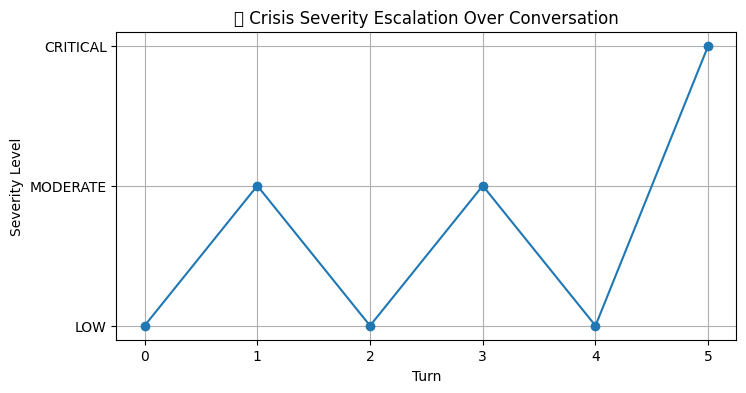

In [89]:
# Cell 39 — Crisis Severity Trend

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(conversation_log)

plt.figure(figsize=(8,4))
plt.plot(df["severity"], marker="o", linestyle="-")
plt.title("🆘 Crisis Severity Escalation Over Conversation")
plt.xlabel("Turn")
plt.ylabel("Severity Level")
plt.grid(True)
plt.show()


In [90]:
# Cell 40 — Auto-Generate Project Summary (Markdown)

project_summary = f"""
# 🛡️ GuardianAI — Multi-Agent Crisis Safety Response System

GuardianAI is a multi-agent AI system designed to protect users during
dangerous situations such as fire, medical emergencies, emotional distress,
and physical threats.

### 🚀 Key Features
- Automated danger classification (Severity: Low → Critical)
- Live routing to specialized agents (Fire, Medical, Emotional, Threat)
- Streamed, real-time safety response guidance
- Session memory + conversation log export
- Safety compliance and critical intervention triggers

### 🧠 How it Works
1. Severity detection → measure urgency  
2. Crisis type classification → identify danger  
3. Specialized agent dispatch → targeted guidance  
4. Memory tracking → intelligence over time  

Built using **Google ADK** and **Gemini**, delivered as a **first-response safety assistant**.

### 📎 Artifacts Exported
- `guardian_memory_log.json` (conversation log)
- Project summary auto-generated from final session state

---

This notebook is the final competition submission for:
**Google x Kaggle — Agents for Good Capstone Project**
"""

with open("PROJECT_SUMMARY.md", "w") as f:
    f.write(project_summary)

print("📌 Project summary saved to PROJECT_SUMMARY.md")


📌 Project summary saved to PROJECT_SUMMARY.md
